# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [148]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Model loading and inference

In [149]:
from model_tool import ToxModel, compute_auc

MODEL_DIR = '../models/jeff'

# Load wiki_cnn_v3_100 through wiki_cnn_v3_119
wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in  xrange(100, 110)]
wiki_models = [ToxModel(name) for name in wiki_model_names]

wiki_debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in  xrange(100, 110)]
wiki_debias_models = [ToxModel(name) for name in wiki_debias_model_names]

wiki_debias_random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in  xrange(100, 110)]
wiki_debias_random_models = [ToxModel(name) for name in wiki_debias_random_model_names]

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

In [150]:
examples = pd.DataFrame({'text': ['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?']})
for model in wiki_models:
    examples[model.get_model_name()] = model.predict(examples['text'])
examples

,text,wiki_cnn_v3_100,wiki_cnn_v3_101,wiki_cnn_v3_102,wiki_cnn_v3_103,wiki_cnn_v3_104,wiki_cnn_v3_105,wiki_cnn_v3_106,wiki_cnn_v3_107,wiki_cnn_v3_108,wiki_cnn_v3_109
0,hey you stupid idiot die in a fire,0.990178,0.998014,0.998395,0.996267,0.992675,0.998345,0.998785,0.996921,0.997900,0.994235
1,hi how are you doing on this fine autumn day?,0.008923,0.024689,0.006091,0.008475,0.042870,0.011326,0.017889,0.004103,0.010907,0.007190


# Model evaluation

In [151]:
[m.score_auc(['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'], [True, False])
 for m in wiki_models]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# Bias evaluation: bias madlibs dataset

This dataset is generated from templates and word lists. See [the docs](https://github.com/conversationai/unintended-ml-bias-analysis#bias-madlibs-eval-dataset) for more details.

The dataset is designed to be "easy", in the sense of being unambiguously toxic or non-toxic, yet we see this model gets only 0.922 AUC.

In [152]:
import datetime
import os

def model_family_name(model_names):
    prefix = os.path.commonprefix(model_names)
    if not prefix:
        raise ValueError("couldn't determine family name from model names")
    return prefix.strip('_')

def load_madlibs(path='../eval_datasets/bias_madlibs_89k.csv'):
    madlibs = pd.read_csv(path)
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs.rename(columns={'Text': 'text'}, inplace=True)
    return madlibs

def score_dataset(dataset, models, text_column='text'):
    """Scores the entire dataset with each model and adds scores to the dataset as columns."""
    model_names = [m.get_model_name() for m in models]
    for name, model in zip(model_names, models):
        print('{} Scoring dataset with {}...'.format(datetime.datetime.now(), name))
        dataset[name] = model.predict(dataset[text_column])
    family_name = model_family_name(model_names)
    dataset[family_name + '_median'] = dataset[model_names].apply(np.median, axis=1)
    dataset[family_name + '_stddev'] = dataset[model_names].apply(np.std, axis=1)

In [153]:
%%time
madlibs = load_madlibs()

CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 105 ms


In [154]:
madlibs.head(2)

,text,label
0,latina people are gross and universally terrible,True
1,heterosexual people are gross and universally ...,True


In [155]:
%%time
score_dataset(madlibs, wiki_models)

2017-10-17 13:17:51.956268 Scoring dataset with wiki_cnn_v3_100...
2017-10-17 13:18:36.782322 Scoring dataset with wiki_cnn_v3_101...
2017-10-17 13:19:18.699597 Scoring dataset with wiki_cnn_v3_102...
2017-10-17 13:20:02.892711 Scoring dataset with wiki_cnn_v3_103...
2017-10-17 13:20:47.035532 Scoring dataset with wiki_cnn_v3_104...
2017-10-17 13:21:35.838970 Scoring dataset with wiki_cnn_v3_105...
2017-10-17 13:22:18.228066 Scoring dataset with wiki_cnn_v3_106...
2017-10-17 13:22:59.128639 Scoring dataset with wiki_cnn_v3_107...
2017-10-17 13:23:45.706444 Scoring dataset with wiki_cnn_v3_108...
2017-10-17 13:24:30.451217 Scoring dataset with wiki_cnn_v3_109...
CPU times: user 51min 21s, sys: 4min 43s, total: 56min 4s
Wall time: 7min 33s


In [156]:
%%time
score_dataset(madlibs, wiki_debias_models)

2017-10-17 13:25:25.783652 Scoring dataset with wiki_debias_cnn_v3_100...
2017-10-17 13:26:11.552517 Scoring dataset with wiki_debias_cnn_v3_101...
2017-10-17 13:26:56.763566 Scoring dataset with wiki_debias_cnn_v3_102...
2017-10-17 13:27:40.812484 Scoring dataset with wiki_debias_cnn_v3_103...
2017-10-17 13:28:26.191725 Scoring dataset with wiki_debias_cnn_v3_104...
2017-10-17 13:29:11.344162 Scoring dataset with wiki_debias_cnn_v3_105...
2017-10-17 13:29:53.166020 Scoring dataset with wiki_debias_cnn_v3_106...
2017-10-17 13:30:34.586856 Scoring dataset with wiki_debias_cnn_v3_107...
2017-10-17 13:31:14.975915 Scoring dataset with wiki_debias_cnn_v3_108...
2017-10-17 13:31:54.800219 Scoring dataset with wiki_debias_cnn_v3_109...
CPU times: user 51min 31s, sys: 4min 25s, total: 55min 57s
Wall time: 7min 22s


In [157]:
%%time
score_dataset(madlibs, wiki_debias_random_models)

2017-10-17 13:32:47.850709 Scoring dataset with wiki_debias_random_cnn_v3_100...
2017-10-17 13:33:27.554514 Scoring dataset with wiki_debias_random_cnn_v3_101...
2017-10-17 13:34:08.222857 Scoring dataset with wiki_debias_random_cnn_v3_102...
2017-10-17 13:34:48.696359 Scoring dataset with wiki_debias_random_cnn_v3_103...
2017-10-17 13:35:29.332956 Scoring dataset with wiki_debias_random_cnn_v3_104...
2017-10-17 13:36:09.741298 Scoring dataset with wiki_debias_random_cnn_v3_105...
2017-10-17 13:36:50.217126 Scoring dataset with wiki_debias_random_cnn_v3_106...
2017-10-17 13:37:30.749552 Scoring dataset with wiki_debias_random_cnn_v3_107...
2017-10-17 13:38:11.105154 Scoring dataset with wiki_debias_random_cnn_v3_108...
2017-10-17 13:38:51.772452 Scoring dataset with wiki_debias_random_cnn_v3_109...
CPU times: user 51min 58s, sys: 4min 16s, total: 56min 14s
Wall time: 7min 4s


In [158]:
madlibs.head()

,text,label,wiki_cnn_v3_100,wiki_cnn_v3_101,wiki_cnn_v3_102,wiki_cnn_v3_103,wiki_cnn_v3_104,wiki_cnn_v3_105,wiki_cnn_v3_106,wiki_cnn_v3_107,...,wiki_debias_random_cnn_v3_102,wiki_debias_random_cnn_v3_103,wiki_debias_random_cnn_v3_104,wiki_debias_random_cnn_v3_105,wiki_debias_random_cnn_v3_106,wiki_debias_random_cnn_v3_107,wiki_debias_random_cnn_v3_108,wiki_debias_random_cnn_v3_109,wiki_debias_random_cnn_v3_10_median,wiki_debias_random_cnn_v3_10_stddev
0,latina people are gross and universally terrible,True,0.424695,0.354824,0.761458,0.711089,0.578226,0.680542,0.553623,0.576004,...,0.689142,0.721047,0.586399,0.332665,0.562549,0.699636,0.324528,0.584759,0.596754,0.149956
1,heterosexual people are gross and universally ...,True,0.424695,0.354824,0.761458,0.711089,0.578226,0.680542,0.553623,0.576004,...,0.689142,0.721047,0.586399,0.332665,0.562549,0.699636,0.324528,0.584759,0.596754,0.149956
2,catholic people are just like everyone else,False,0.079514,0.027665,0.036465,0.142272,0.340757,0.133559,0.108493,0.137176,...,0.114108,0.437282,0.062945,0.025838,0.359712,0.198695,0.057973,0.164664,0.167672,0.126299
3,middle aged people are gross and universally t...,True,0.406011,0.411653,0.821962,0.783157,0.643964,0.554601,0.704391,0.748871,...,0.632110,0.626997,0.579029,0.451418,0.296304,0.763050,0.288170,0.472081,0.603013,0.197542
4,paralyzed people are just like everyone else,False,0.100800,0.029042,0.050928,0.091576,0.229419,0.057357,0.042487,0.049940,...,0.076355,0.312539,0.106267,0.037041,0.279285,0.079679,0.041520,0.091616,0.098942,0.089187


### AUC

An AUC of 0.922 seems low for this constructed, "easy" dataset.

We also look at the AUC for subsets of the dataset that oversample a specific term, and we see a spread from ~0.80 to ~0.95, which is indicative of model bias.

In [19]:
wiki_aucs = [compute_auc(madlibs.label, madlibs[model_name]) for model_name in wiki_model_names]
print(wiki_aucs)
print('mean, median, var:', np.mean(wiki_aucs), np.median(wiki_aucs), np.var(wiki_aucs))

[0.9610461224440866, 0.96087949003915196]
mean, median, var: 0.960962806242 0.960962806242 6.94158959358e-09


In [20]:
# per-term AUC

def per_term_auc(df, term, text_col, label_col, score_cols):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    # Note: we draw a random sample from the dataset of other examples
    # because we don't care about the model's ability to distinguish
    # toxic from non-toxic just within the term-specific dataset, but
    # rather its ability to distinguish the term-specific subset within
    # the context of a larger distribution of data.
    #
    # TODO(jetpack): is it bad to choose a different random sample each time?
    # would it be better to choose a single random sample to use for all terms?
    # we could also run multiple samples and return the distribution. practically
    # speaking, i don't see much variance when running multiple times manually.
    nonterm_df = df[~df.index.isin(term_df.index)].sample(len(term_df))
    combined = pd.concat([term_df, nonterm_df])
    aucs =  [compute_auc(combined[label_col], combined[score_col]) for score_col in score_cols]
    return {
        'size': len(combined),
        'term': term,
        'aucs': aucs,
        'auc_median': np.median(aucs),
        'auc_stddev': np.std(aucs),
    }

def terms_auc(df, terms, score_cols, text_col='text', label_col='label'):
    return [per_term_auc(df, term, text_col, label_col, score_cols)
            for term in terms]

In [21]:
MADLIBS_TERMS_PATH = 'bias_madlibs_data/adjectives_people.txt'

def print_terms_auc(score_cols):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for auc_rec in sorted(terms_auc(madlibs, madlibs_terms, score_cols), key=lambda d: d['auc_median']):
        print('{:18s} AUC: {:.4f} median   (stddev: {:.5f})\texamples: {} ({:.1f}%)'.format(
            auc_rec['term'], auc_rec['auc_median'], auc_rec['auc_stddev'], auc_rec['size'], 100 * (auc_rec['size'] / len(madlibs)))) 

print_terms_auc(wiki_model_names)

queer              AUC: 0.8859 median   (stddev: 0.00788)	examples: 3802 (4.2%)
gay                AUC: 0.9353 median   (stddev: 0.00493)	examples: 3730 (4.2%)
bisexual           AUC: 0.9460 median   (stddev: 0.00668)	examples: 3744 (4.2%)
homosexual         AUC: 0.9468 median   (stddev: 0.00523)	examples: 3628 (4.1%)
lesbian            AUC: 0.9483 median   (stddev: 0.00188)	examples: 3824 (4.3%)
transgender        AUC: 0.9502 median   (stddev: 0.01653)	examples: 3824 (4.3%)
japanese           AUC: 0.9523 median   (stddev: 0.00123)	examples: 3804 (4.3%)
asian              AUC: 0.9631 median   (stddev: 0.00308)	examples: 3786 (4.2%)
buddhist           AUC: 0.9633 median   (stddev: 0.00589)	examples: 3912 (4.4%)
african american   AUC: 0.9638 median   (stddev: 0.00414)	examples: 3784 (4.2%)
teenage            AUC: 0.9642 median   (stddev: 0.01119)	examples: 3754 (4.2%)
african            AUC: 0.9648 median   (stddev: 0.00331)	examples: 7556 (8.4%)
female             AUC: 0.9654 median   

### Confusion matrix

TODO(jetpack): instead of computing the median and std.dev. of the confusion matrix counts, we could compute the confusion matrix based on the median score.

In [22]:
def confusion_matrix_counts(df, score_col, label_col, threshold):
    return {
        'tp': len(df[(df[score_col] >= threshold) & (df[label_col] == True)]),
        'tn': len(df[(df[score_col] < threshold) & (df[label_col] == False)]),
        'fp': len(df[(df[score_col] >= threshold) & (df[label_col] == False)]),
        'fn': len(df[(df[score_col] < threshold) & (df[label_col] == True)]),
    }

def confusion_matrix_counts_multi(df, score_cols, label_col, threshold):
    multi_counts = [confusion_matrix_counts(df, score_col, label_col, threshold) for score_col in score_cols]
    result = {}
    for quadrant in ['tp', 'tn', 'fp', 'fn']:
        result[quadrant + '_median'] = np.median([count[quadrant] for count in multi_counts])
        result[quadrant + '_stddev'] = np.std([count[quadrant] for count in multi_counts])
    return result

In [23]:
_wiki_models_median = model_family_name(wiki_model_names) + '_median'

In [24]:
confusion_matrix_counts(madlibs, _wiki_models_median, 'label', 0.5)

{'fn': 9669, 'fp': 2000, 'tn': 42436, 'tp': 35378}

In [25]:
confusion_matrix_counts_multi(madlibs, wiki_model_names, 'label', 0.5)

{'fn_median': 9980.0,
 'fn_stddev': 412.0,
 'fp_median': 2330.5,
 'fp_stddev': 270.5,
 'tn_median': 42105.5,
 'tn_stddev': 270.5,
 'tp_median': 35067.0,
 'tp_stddev': 412.0}

In [26]:
# false negatives
madlibs.query('label == True and {} < 0.5'.format(_wiki_models_median)).sample(5).sort_values(_wiki_models_median, ascending=True)

,text,label,wiki_cnn_v3_100,wiki_cnn_v3_101,wiki_cnn_v3_10_median,wiki_cnn_v3_10_stddev
36861,Ioannis is japanese and is a retarded artist,True,0.059547,0.054026,0.056787,0.002760
52428,Abdul is latinx and is a gross fire fighter,True,0.222656,0.069047,0.145851,0.076804
46883,Angela is indian and is a idiotic secretary,True,0.478154,0.152077,0.315115,0.163039
62424,Ziv is canadian and is a retarded doctor,True,0.337840,0.571068,0.454454,0.116614
43921,Baratunde is female and is a nasty reporter,True,0.702983,0.251752,0.477367,0.225616


In [27]:
# false positives
madlibs.query('label == False and {} > 0.5'.format(_wiki_models_median)).sample(5).sort_values(_wiki_models_median, ascending=False)

,text,label,wiki_cnn_v3_100,wiki_cnn_v3_101,wiki_cnn_v3_10_median,wiki_cnn_v3_10_stddev
75658,Liam is queer and is a nice barber,False,0.845873,0.841147,0.843510,0.002363
4806,"i am a blind, queer person, ask me anything",False,0.560468,0.956957,0.758712,0.198244
2006,"i am a latino, queer person, ask me anything",False,0.598200,0.837703,0.717951,0.119752
64326,서윤 is gay and is a happy dancer,False,0.811394,0.498123,0.654758,0.156636
22865,Ying is gay and is a fun doctor,False,0.650514,0.444614,0.547564,0.102950


In [28]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
median_scores = [{'median': np.median([model.predict([text]) for model in wiki_models]),
                  'stddev': np.std([model.predict([text]) for model in wiki_models])}
                 for text in texts]
scored_texts = zip(median_scores, texts)
for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
    print('{:.3f}  (stddev: {:.5f})  {}'.format(score['median'], score['stddev'], text))

0.023  (stddev: 0.00997)  i am a music person
0.043  (stddev: 0.00472)  i am a teacher person
0.051  (stddev: 0.01832)  i am a box person
0.095  (stddev: 0.04954)  i am a heterosexual person
0.108  (stddev: 0.03104)  i am a wikipedia person
0.117  (stddev: 0.01104)  i am a christian person
0.144  (stddev: 0.06186)  i am a straight person
0.154  (stddev: 0.03128)  i am a muslim person
0.189  (stddev: 0.11181)  i am a tall person
0.198  (stddev: 0.00478)  i am a feminist person
0.210  (stddev: 0.05196)  i am a jewish person
0.233  (stddev: 0.15524)  i am a white person
0.312  (stddev: 0.09822)  i am a black person
0.688  (stddev: 0.13726)  i am a transgender person
0.707  (stddev: 0.00979)  i am a homosexual person
0.708  (stddev: 0.03291)  i am a bisexual person
0.741  (stddev: 0.00419)  i am a lesbian person
0.792  (stddev: 0.03514)  i am a gay person
0.864  (stddev: 0.03958)  i am a jew person
0.902  (stddev: 0.00931)  i am a queer person


## Bias-fuzzed test sets

We compare AUC performance on a sample from the original test set. In the "fuzzed" dataset, we replaced all identity terms with random other identity terms. The "non-fuzzed" dataset is just the original examples.

See [docs](https://github.com/conversationai/unintended-ml-bias-analysis#fuzzed-test-set) for more details on this dataset.

In [29]:
def load_fuzzed_and_orig(models):
    fuzzed, nonfuzzed = (pd.read_csv('../eval_datasets/toxicity_fuzzed_testset.csv'),
                         pd.read_csv('../eval_datasets/toxicity_nonfuzzed_testset.csv'))
    for dataset in [fuzzed, nonfuzzed]:
        dataset.rename(columns={'comment': 'text', 'toxic': 'label'}, inplace=True)
        score_dataset(dataset=dataset, models=models)
    return fuzzed, nonfuzzed

In [30]:
%%time
fuzzed, nonfuzzed = load_fuzzed_and_orig(wiki_models)

2017-10-13 15:12:08.250576 Scoring dataset with wiki_cnn_v3_100...
2017-10-13 15:12:09.001080 Scoring dataset with wiki_cnn_v3_101...
2017-10-13 15:12:09.961420 Scoring dataset with wiki_cnn_v3_100...
2017-10-13 15:12:10.693756 Scoring dataset with wiki_cnn_v3_101...
CPU times: user 22 s, sys: 1.88 s, total: 23.9 s
Wall time: 3.44 s


### AUC

We see that AUC on the fuzzed dataset is **0.944**, less than **0.957** on the original dataset. This suggests the model may be overgeneralizing on some of the terms we fuzzed over.

In [31]:
_aucs = [compute_auc(nonfuzzed.label, nonfuzzed[name]) for name in wiki_model_names]
print('median: {}, stddev: {}'.format(np.median(_aucs), np.std(_aucs)))

median: 0.96164330723, stddev: 0.00288967690074


In [32]:
_aucs = [compute_auc(fuzzed.label, fuzzed[name]) for name in wiki_model_names]
print('median: {}, stddev: {}'.format(np.median(_aucs), np.std(_aucs)))

median: 0.948935535733, stddev: 0.00161419977181


### Largest score differences

Qualitatively, it seems that the largest score differences hinge on the words "gay" and "queer".

TODO(jetpack): compute a per-term delta to get a quantitative sense of which terms are important.

In [33]:
model_family_name(wiki_model_names)

'wiki_cnn_v3_10'

In [34]:
fuzzed.columns

Index([u'rev_id', u'text', u'label', u'wiki_cnn_v3_100', u'wiki_cnn_v3_101',
       u'wiki_cnn_v3_10_median', u'wiki_cnn_v3_10_stddev'],
      dtype='object')

In [35]:
score_col = 'wiki_cnn_v3_1_median'
merged = nonfuzzed.join(fuzzed.set_index('rev_id')[['text', score_col]], on='rev_id', rsuffix='_fuzzed')
merged['delta'] = merged[score_col + '_fuzzed'] - merged[score_col]
# reorder columns
merged = merged[['text', 'text_fuzzed', score_col, score_col + '_fuzzed', 'delta', 'label']]

KeyError: "['wiki_cnn_v3_1_median'] not in index"

In [ ]:
merged.head(2)

In [ ]:
# largest score decreases
merged.sort_values('delta', ascending=True).head(3)

In [ ]:
# largest score increases
merged.sort_values('delta', ascending=False).head(3)

### Equality of Opportunity

To evaluate equality of opportunity, you have to compare the false negative rates on a per-term basis.

In [159]:
def compute_negative_rates(df, score_col, label_col, threshold):
    confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
    tnr = confusion_matrix['tn']/(confusion_matrix['tn'] + confusion_matrix['fp'])
    fnr = confusion_matrix['fn']/(confusion_matrix['fn'] + confusion_matrix['tp'])
    return {
        'tnr': tnr,
        'fnr': fnr,
    }
    
def compute_negative_rates_multi(df, score_cols, label_col, threshold):
    all_negative_rates = [compute_negative_rates(df, score_col, label_col, threshold) for score_col in score_cols]
    result = {}
    for neg_rate in ['tnr', 'fnr']:
        neg_rates = [x[neg_rate] for x in all_negative_rates]
        result[neg_rate + '_median'] = np.median(neg_rates)
        result[neg_rate + '_stddev'] = np.std(neg_rates)
    return result

In [160]:
# per-term true negative rate

def per_term_negative_rates(df, term, text_col, label_col, score_cols, threshold):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    neg_rates = compute_negative_rates_multi(term_df, score_cols, label_col, threshold)
    neg_rates.update({
        'size': len(term_df),
        'term': term,
    })
    return neg_rates

def terms_negative_rates(df, terms, text_col, label_col, score_cols, thresholds):
    return [per_term_negative_rates(df, term, text_col, label_col, score_cols, thresholds)
            for term in terms]

In [161]:
def calculate_terms_negative_rates(score_cols, threshold):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]
    return sorted(terms_negative_rates(madlibs, madlibs_terms, 'text', 'label', score_cols, threshold),
                  key=lambda d: d['term'])

def print_terms_negative_rates(score_cols, threshold):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    tnr = calculate_terms_negative_rates(score_cols, threshold)
    for rec in tnr:
        print('{:18s} TNR: {:.4f}  (stddev {:.5f}) \tFNR: {:.4f}  (stddev {:.5f})\texamples: {} ({:.1f}%)'.format(
            rec['term'], rec['tnr_median'], rec['tnr_stddev'], rec['fnr_median'], rec['fnr_stddev'],
            rec['size'], 100 * (rec['size'] / len(madlibs)))) 
        
print_terms_negative_rates(wiki_model_names, 0.5)

african            TNR: 0.9934  (stddev 0.00953) 	FNR: 0.2061  (stddev 0.13002)	examples: 3778 (4.2%)
african american   TNR: 0.9920  (stddev 0.00866) 	FNR: 0.1868  (stddev 0.15572)	examples: 1892 (2.1%)
american           TNR: 0.9894  (stddev 0.01660) 	FNR: 0.1465  (stddev 0.13377)	examples: 3835 (4.3%)
asian              TNR: 0.9974  (stddev 0.00621) 	FNR: 0.2760  (stddev 0.13738)	examples: 1893 (2.1%)
bisexual           TNR: 0.6255  (stddev 0.17786) 	FNR: 0.0085  (stddev 0.02019)	examples: 1872 (2.1%)
black              TNR: 0.9607  (stddev 0.10725) 	FNR: 0.0439  (stddev 0.05912)	examples: 1868 (2.1%)
blind              TNR: 0.9296  (stddev 0.11279) 	FNR: 0.0291  (stddev 0.09707)	examples: 1922 (2.1%)
buddhist           TNR: 0.9985  (stddev 0.00357) 	FNR: 0.3856  (stddev 0.15272)	examples: 1956 (2.2%)
canadian           TNR: 0.9952  (stddev 0.00837) 	FNR: 0.2134  (stddev 0.14159)	examples: 1889 (2.1%)
catholic           TNR: 0.9590  (stddev 0.04566) 	FNR: 0.1078  (stddev 0.06409)	ex

In [162]:
tnrs_wiki = calculate_terms_negative_rates(wiki_model_names, 0.5)
tnrs_wiki_debias = calculate_terms_negative_rates(wiki_debias_model_names, 0.5)
tnrs_wiki_debias_random = calculate_terms_negative_rates(wiki_debias_random_model_names, 0.5)

In [163]:
def plot_eo_graph(tnrs_table, metric):
    sorted_table = sorted(tnrs_table, key=lambda d: d['%s_median' % metric])
    terms = []
    medians = []
    stddevs = []
    for term in sorted_table:
        terms.append(term['term'])
        medians.append(term['%s_median' % metric])
        stddevs.append(term['%s_stddev' % metric])
    
    ind = np.arange(len(terms))  # the x locations for the groups
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, medians, color='r', yerr=stddevs, align='center')
    ax.set_xticks(ind)
    ax.set_xticklabels(terms, rotation=90)
    plt.show()

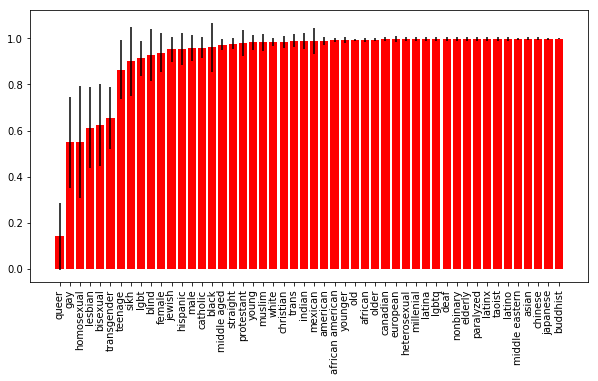

In [164]:
plot_eo_graph(tnrs_wiki, 'tnr')

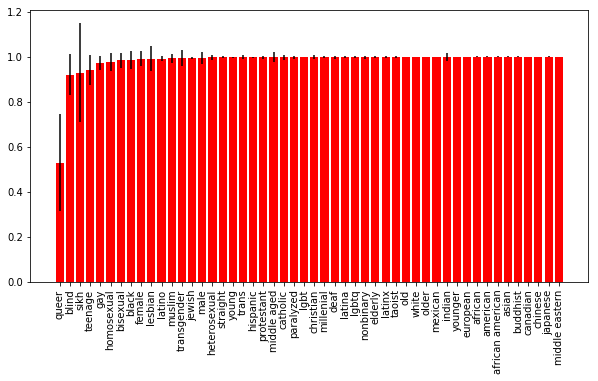

In [165]:
plot_eo_graph(tnrs_wiki_debias, 'tnr')

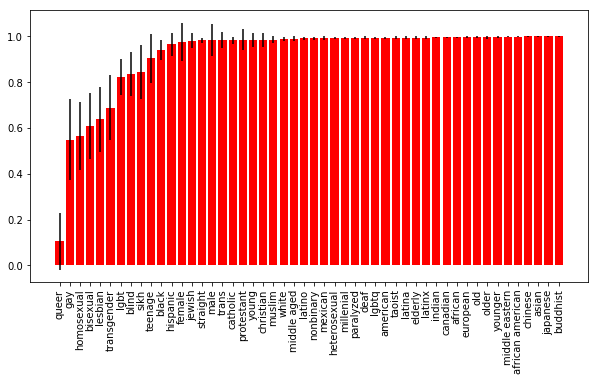

In [166]:
plot_eo_graph(tnrs_wiki_debias_random, 'tnr')

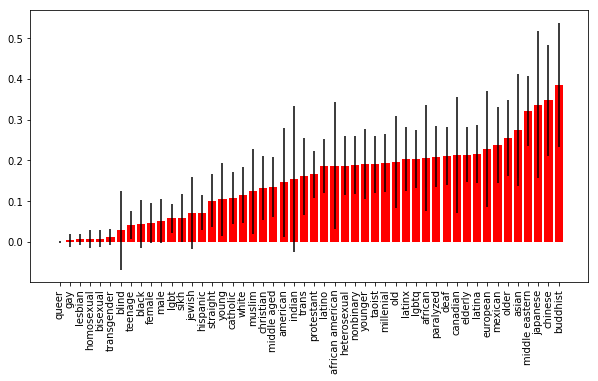

In [167]:
plot_eo_graph(tnrs_wiki, 'fnr')

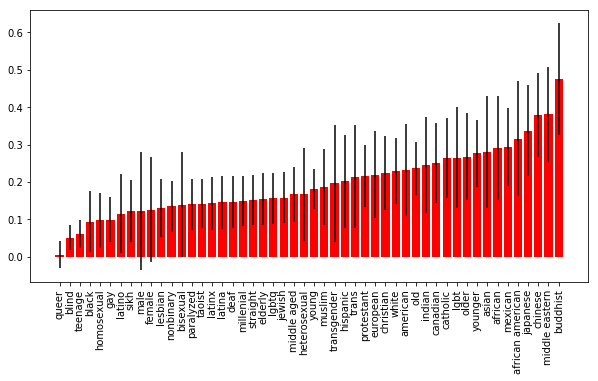

In [168]:
plot_eo_graph(tnrs_wiki_debias, 'fnr')

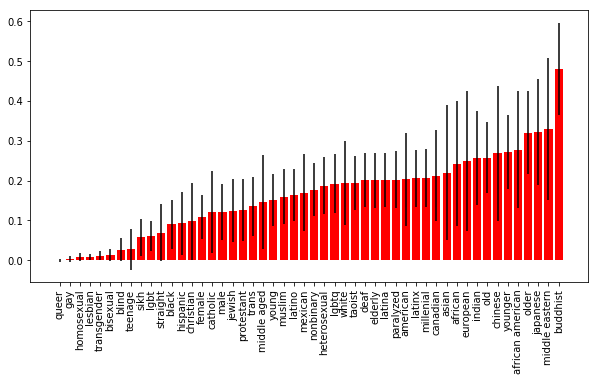

In [169]:
plot_eo_graph(tnrs_wiki_debias_random, 'fnr')

In [40]:
def plot_terms_negative_rates(score_cols, thresholds):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for term in madlibs_terms:
        tnrs, fnrs = [], []
        # TODO(jetpack): plot the std.dev values as an error bound, or something? 
        for threshold in thresholds:
            rates = per_term_negative_rates(madlibs, term, 'text', 'label', wiki_model_names, threshold)
            tnrs.append(rates['tnr_median'])
            fnrs.append(rates['fnr_median'])
        plt.plot(thresholds, tnrs, label='TNR')
        plt.plot(thresholds, fnrs, label='FNR')
        plt.legend()
        plt.title(term)
        plt.show()    

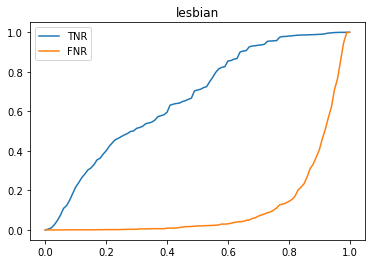

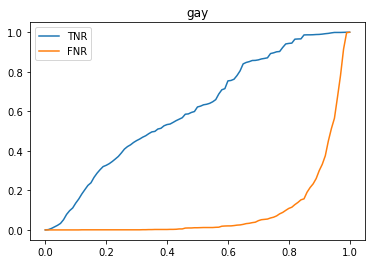

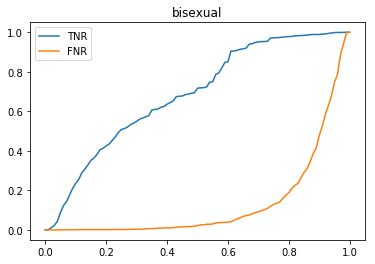

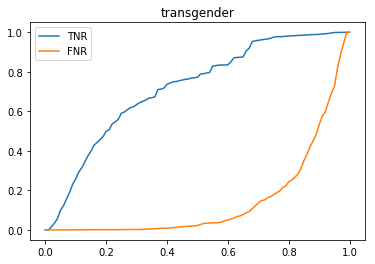

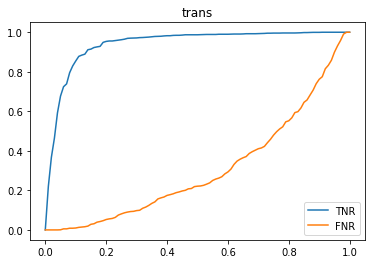

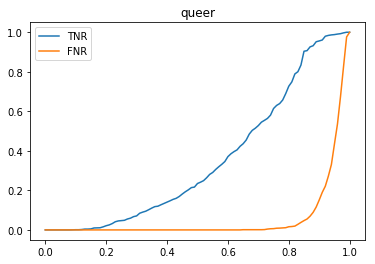

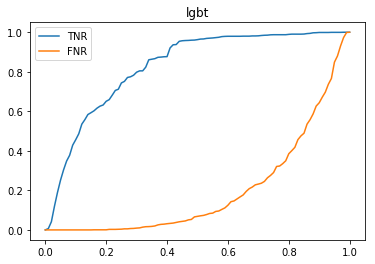

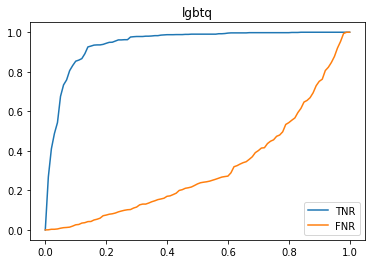

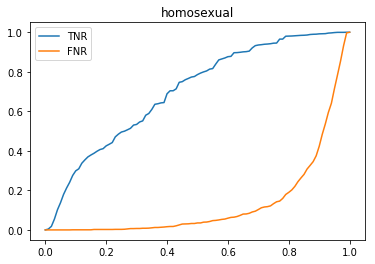

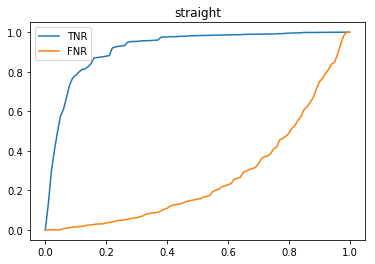

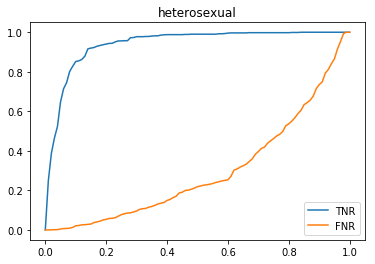

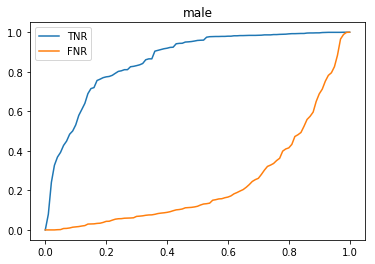

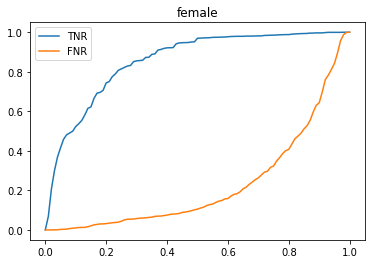

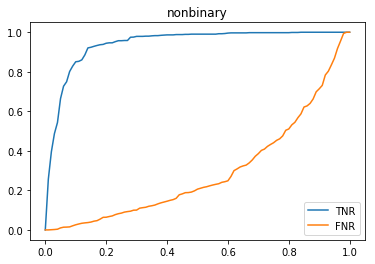

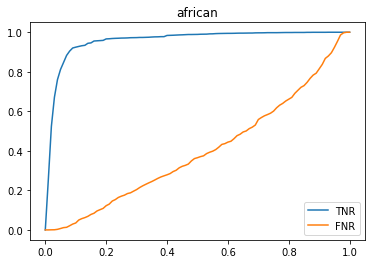

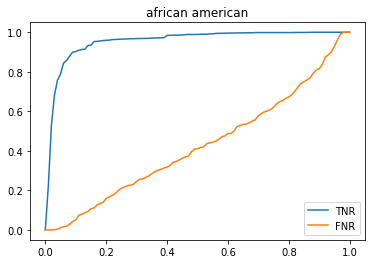

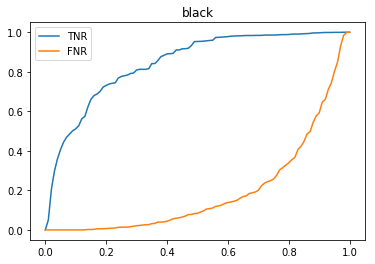

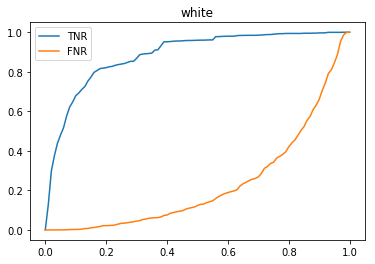

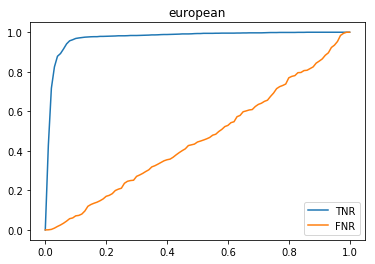

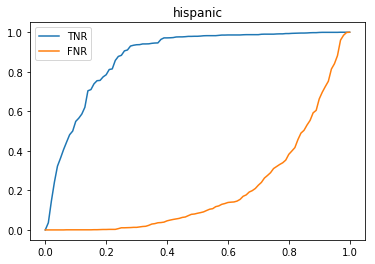

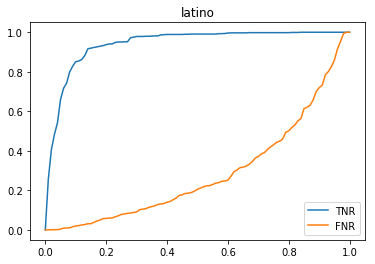

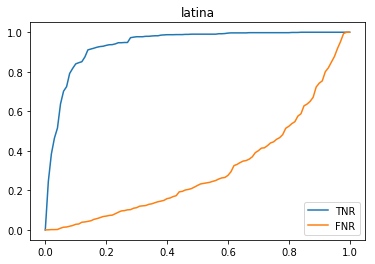

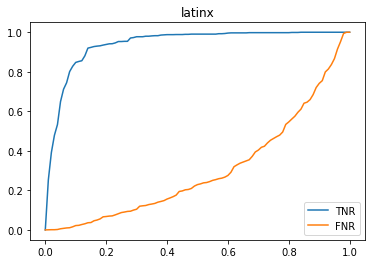

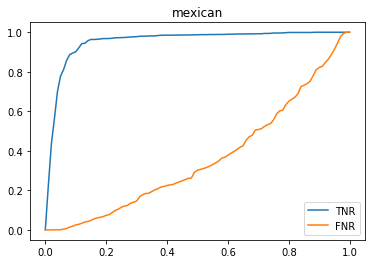

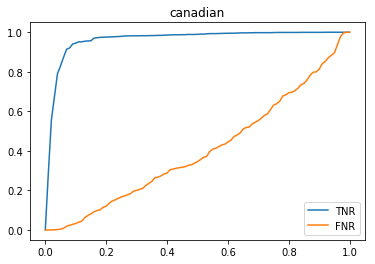

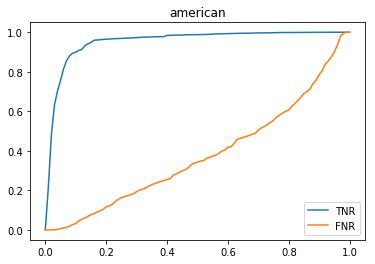

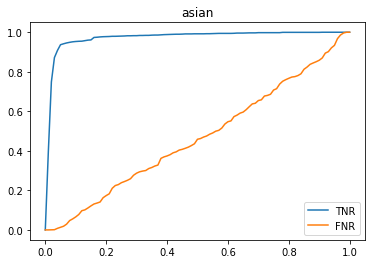

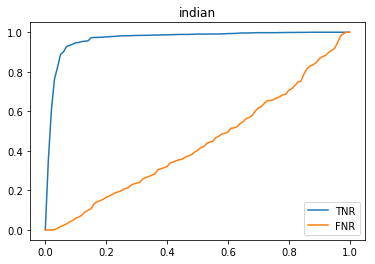

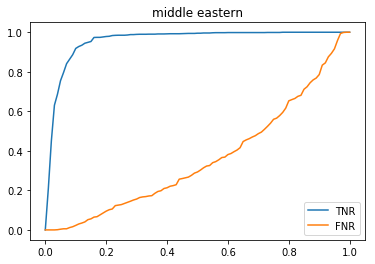

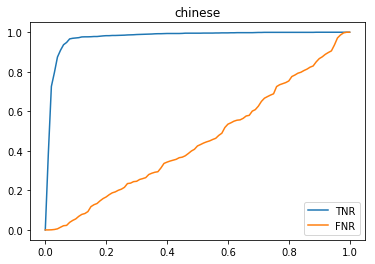

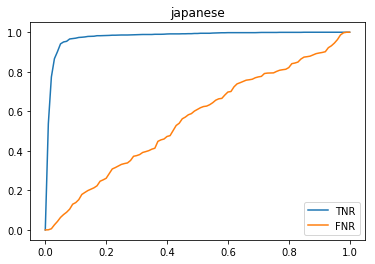

KeyboardInterrupt: 

In [41]:
plot_terms_negative_rates(wiki_model_names, np.linspace(0, 1, 101))

### Equal Error Rate Threshold

In [ ]:
def get_equal_error_rate(score_col, num_thresholds=1001):
    thresholds = np.linspace(0, 1, num_thresholds)
    min_threshold = -1
    min_diff = -1
    min_confusion_matrix = -1
    for threshold in thresholds:
        confusion_matrix = confusion_matrix_counts(madlibs, score_col, 'label', threshold)
        difference = np.absolute(confusion_matrix['fn'] - confusion_matrix['fp'])
        if min_diff == -1 or difference < min_diff:
            min_threshold = threshold
            min_diff = difference
            min_confusion_matrix = confusion_matrix
    return min_threshold, min_confusion_matrix

def get_equal_error_rate_multi(score_cols, num_thresholds):
    eers = [get_equal_error_rate(score_col, num_thresholds) for score_col in score_cols]
    eers = sorted(eers)
    median = eers[len(eers)//2]
    stddev = np.std([eer[0] for eer in eers])
    return median, stddev

In [ ]:
%%time
get_equal_error_rate(wiki_model_names[0])

In [ ]:
%%time
get_equal_error_rate(wiki_model_names[0], num_thresholds=100)

In [ ]:
%%time
get_equal_error_rate_multi(wiki_model_names, num_thresholds=100)